In [ ]:
!pip install -q kaggle
!pip install dask
!pip install 'fsspec>=0.3.3'
!pip install -U sentence-transformers

     |████████████████████████████████| 102kB 7.9MB/s 
     |████████████████████████████████| 71kB 6.2MB/s 
     |████████████████████████████████| 1.3MB 21.9MB/s 
     |████████████████████████████████| 890kB 19.4MB/s 
     |████████████████████████████████| 2.9MB 56.4MB/s 
     |████████████████████████████████| 1.1MB 56.9MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-0.3.9-cp36-none-any.whl size=101034 sha256=208f923f70644119c66003abed27d94a9a439c15a350a4cb21878ae7d19d483f
  Stored in directory: /root/.cache/pip/wheels/fc/89/43/f2f5bc00b03ef9724b0f6254a97eaf159a4c4ddc024b33e07a
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=32a8c2794b689168ca1cc3774dbabd92b15da3ca188f7e0dfdba63a9244f42ed
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sentence-transformers sacremoses


In [ ]:
import numpy as np
import pandas as pd
import dask.bag as db
import json
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer


In [ ]:
get_latest_version = lambda x: x['versions'][-1]['created']
SEED=10
def split_data(df_):
  train, test = train_test_split(df_, random_state=SEED, test_size=0.15, shuffle=True)
  return train,test

def create_sample(df_,num_of_records=250000):
  result = df_.sample(num_of_records,random_state=SEED)
  return result,df_




In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"tomco24","key":"bcad18e79f8996f99376f96a1a5c2dbe"}'}

In [ ]:
#Download dataset from kaggle

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d Cornell-University/arxiv
!unzip arxiv.zip

 98% 887M/906M [00:16<00:00, 55.8MB/s]
100% 906M/906M [00:16<00:00, 57.0MB/s]
Archive:  arxiv.zip
  inflating: arxiv-metadata-oai-snapshot.json  


In [ ]:
docs = db.read_text('./arxiv-metadata-oai-snapshot.json').map(json.loads)
trim = lambda x: {'id': x['id'],
                  'title': x['title'],
                  'category':x['categories'].split(' '),
                  'abstract':x['abstract']}
# filter for papers published on or after 2019-01-01
columns = ['id','category','abstract']
docs_df = (docs
             .filter(lambda x: int(get_latest_version(x).split(' ')[3]) > 2018)
             .map(trim)
             .compute())

# convert to pandas
docs_df = pd.DataFrame(docs_df)

#Filtering just general category
docs_df['general_category'] = docs_df.category.apply(lambda x:[a.split('.')[0] for a in x])
docs_df['general_category']= docs_df['general_category'].apply(lambda x:pd.Series(x).unique())

# Tranforming output variable to one-hot encoded output features
mlb = MultiLabelBinarizer(sparse_output=True)

# Construing final dataframe
df = docs_df.join(
            pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(docs_df.pop('general_category')),
                index=docs_df.index,
                columns=mlb.classes_))
df = df.drop("category",axis=1)

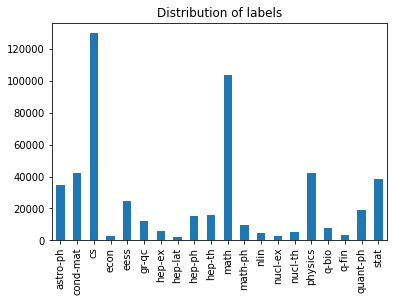

In [ ]:
categories_cols = df.columns[3:]
labels = df[categories_cols]
#Remove labels with less than one example
labels_to_remove = labels[labels.columns[labels.sum(axis=0) <2]].columns
df = df.drop(labels_to_remove,axis=1)
categories_cols = df.columns[3:]
labels = df[categories_cols]

plt.title("Distribution of labels")
labels.sum(axis=0).plot.bar()


## Models & Implementation

### SBERT Embeddings and NN clasifier


#### Embedding

In [ ]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
import re
from sentence_transformers import SentenceTransformer


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def encode_by_parts(data,step,start=0,index=[]):
  #!rm -R bert/
  #!mkdir bert
  count_parts = len(data)//step
  print(len(data))
  for i in range(count_parts+1):
    s = start +(step*i)
    e = start +(step*(i+1))
    print(len(data[s:e]))
    #print(s,e)
    embeddings = sbert_model.encode(data[s:e],show_progress_bar=True)
    idxs = index[s:e]
    np.save("bert/bert_{}_{}".format(s,e),embeddings)
    np.save("bert/bert_{}_{}_index".format(s,e),idxs)

def load_by_parts(length,step=10000,start=0,index=True,folder='bert'):
    result = np.array([])
    count_parts = length//step
    for i in range(count_parts+1):
      s = start +(step*i)
      e = start +(step*(i+1))
      path = "bert/bert_{}_{}.npy".format(s,e)
      values = np.load(path)
      result = np.append(result,values,axis=0) if result.any() else values
    return result


def load_pickles(download=True):
  if download:
    !wget -O pickles.zip https://owncloud.cesnet.cz/index.php/s/xuBFAEu8GPG2DZY/download
    !unzip pickles.zip
  train = pd.read_pickle("train_bert.pkl")
  test= pd.read_pickle("test_bert.pkl")
  X_train = np.load("train_bert_vecs.npy")
  X_test= np.load("test_bert_vecs.npy")
  return train,test,X_train,X_test



  

In [ ]:
sbert_model = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')
#Cleaning documents
stop_words_l=stopwords.words('english')
df['cleaned_docs'] = df.abstract.apply(lambda x: " ".join(re.sub(r'[^a-zA-Z]',' ',w).lower() for w in x.split() if re.sub(r'[^a-zA-Z]',' ',w).lower() not in stop_words_l) )

train,test = split_data(df)
#-----
X_train = sbert_model.encode(train.cleaned_docs.values,show_progress_bar=True)
X_test = sbert_model.encode(test.cleaned_docs.values,show_progress_bar=True)
y_train = train[categories_cols]
y_test = test[categories_cols]

100%|██████████| 245M/245M [00:05<00:00, 42.6MB/s]


#### Classifier

In [ ]:
# Neural Network model
from keras.models import Sequential
from keras.layers import Dense,LSTM
from keras.optimizers import SGD
from sklearn.metrics import accuracy_score, hamming_loss
from keras import backend as K

In [ ]:
def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    '''
    Compute the Hamming score (a.k.a. label-based accuracy) for the multi-label case
    http://stackoverflow.com/q/32239577/395857
    '''
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        #print('\nset_true: {0}'.format(set_true))
        #print('set_pred: {0}'.format(set_pred))
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        #print('tmp_a: {0}'.format(tmp_a))
        acc_list.append(tmp_a)
    return np.mean(acc_list)
def predict_using_model(model):
  preds = model.predict(X_test)
  print(preds)
  preds[preds>=0.5] = 1
  preds[preds<0.5] = 0
  return preds
  
def multilabel_accuracy(y_true,y_pred):
  comp = K.equal(y_true, K.round(y_pred))
  return K.cast(K.all(comp, axis=-1), K.floatx())
def plot_loss(history):
  plt.plot(history.history['loss'], label='MAE (training data)')
  plt.title('MAE')
  plt.ylabel('MAE value')
  plt.xlabel('No. epoch')
  plt.legend(loc="upper left")
  plt.show()
  plt.plot(history.history['multilabel_accuracy'])
  plt.title('Multilabel accuracy')
  plt.ylabel('Value')
  plt.xlabel('No. epoch')
  plt.legend(loc="upper left")
  plt.show()
def baseline_model():
	# create model
  model = Sequential()
  model.add(Dense(384,activation='relu',input_shape=(768,)))
  #model.add(layers.LSTM(128))
  model.add(Dense(384,activation='relu'))
  model.add(Dense(384,activation='relu'))
  model.add(Dense(192,activation='relu'))
  model.add(Dense(192,activation='relu'))
  model.add(Dense(192,activation='relu'))
  model.add(Dense(192,activation='relu'))
  model.add(Dense(192,activation='relu'))
  model.add(Dense(192,activation='relu'))
  model.add(Dense(192,activation='relu'))
  model.add(Dense(192,activation='relu'))
  model.add(Dense(192,activation='relu'))
  model.add(Dense(192,activation='relu'))
  model.add(Dense(20, activation='sigmoid'))
	# Compile model
  sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',multilabel_accuracy])
  return model

def thin_model(layers=12):
  model = Sequential()
  model.add(Dense(192,activation='relu',input_shape=(768,)))
  for i in range(layers):
    model.add(Dense(96,activation='relu'))
  model.add(Dense(20, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',multilabel_accuracy])
  return model

def combined_model(tlayers=7,wlayers=3):
  model = Sequential()
  model.add(Dense(384,activation='relu',input_shape=(768,)))
  for i in range(wlayers):
    model.add(Dense(384,activation='relu'))
  for i in range(tlayers):
    model.add(Dense(192,activation='relu'))
  model.add(Dense(20, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',multilabel_accuracy])
  return model




In [ ]:
#Model training
model_sbert = baseline_model()
history = model_sbert.fit(X_train,y_train,epochs=19,batch_size=128,validation_data=(X_test,y_test))

Epoch 1/19
2370/2370 [==============================] - 10s 4ms/step - loss: 0.1104 - accuracy: 0.7068 - multilabel_accuracy: 0.4976 - val_loss: 0.0937 - val_accuracy: 0.7456 - val_multilabel_accuracy: 0.5557
Epoch 2/19
2370/2370 [==============================] - 9s 4ms/step - loss: 0.0915 - accuracy: 0.7451 - multilabel_accuracy: 0.5603 - val_loss: 0.0904 - val_accuracy: 0.7631 - val_multilabel_accuracy: 0.5580
Epoch 3/19
2370/2370 [==============================] - 9s 4ms/step - loss: 0.0873 - accuracy: 0.7527 - multilabel_accuracy: 0.5720 - val_loss: 0.0873 - val_accuracy: 0.7553 - val_multilabel_accuracy: 0.5741
Epoch 4/19
2370/2370 [==============================] - 9s 4ms/step - loss: 0.0845 - accuracy: 0.7573 - multilabel_accuracy: 0.5811 - val_loss: 0.0852 - val_accuracy: 0.7624 - val_multilabel_accuracy: 0.5809
Epoch 5/19
2370/2370 [==============================] - 9s 4ms/step - loss: 0.0822 - accuracy: 0.7605 - multilabel_accuracy: 0.5880 - val_loss: 0.0847 - val_accuracy: 

[[2.6575604e-04 9.6964318e-01 1.4104506e-04 ... 2.0134532e-09
  7.3799132e-03 3.2278251e-06]
 [9.4142753e-01 1.4835774e-02 1.1639885e-04 ... 7.5050819e-09
  1.8777176e-03 2.0492815e-04]
 [3.0221613e-04 3.9735175e-04 9.9582410e-01 ... 4.7899873e-04
  9.3656541e-05 2.3460220e-01]
 ...
 [2.1372328e-03 2.4019767e-01 1.5256403e-01 ... 1.2803520e-02
  9.6601248e-01 4.8877228e-02]
 [3.8595829e-07 8.8261388e-04 1.4103624e-02 ... 1.2555835e-04
  1.2255990e-03 4.4389578e-04]
 [8.8765137e-03 5.4508591e-01 1.2124141e-01 ... 5.8422452e-03
  2.8391421e-02 1.1091445e-01]]
Hamming loss : 0.031160192088495246
Accuracy : 0.5948203374628622


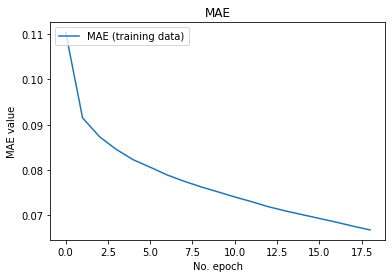

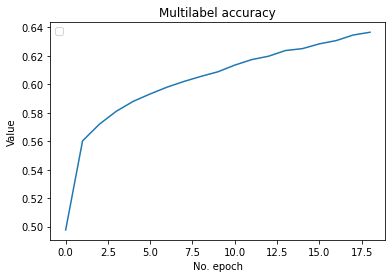

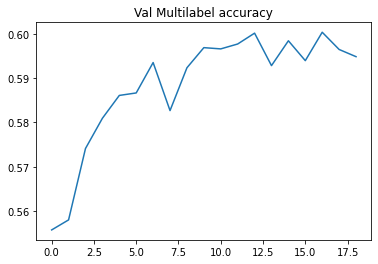

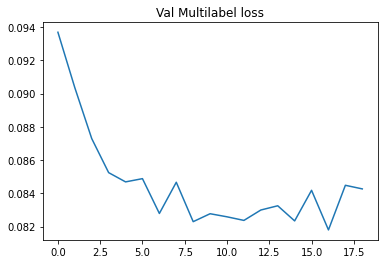

In [ ]:
y_pred = predict_using_model(model_sbert)

# to evaluate the multi label classification model use below metrics
print('Hamming loss : {}'.format(hamming_loss(y_test,y_pred)))
print('Accuracy : {}'.format(accuracy_score(y_test,y_pred)))

plot_loss(history)

plt.title("Val Multilabel accuracy")
plt.plot(history.history['val_multilabel_accuracy'])
plt.show()

plt.title("Val Multilabel loss")
plt.plot(history.history['val_loss'])
plt.show()


###Doc2Vec

#### Embedding

In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.parsing.preprocessing import preprocess_string
from keras import optimizers
from sklearn.metrics import accuracy_score, hamming_loss
from keras.models import Sequential
from keras.layers import Dense,LSTM
from keras.optimizers import SGD
from sklearn.metrics import accuracy_score, hamming_loss
from keras import backend as K

In [ ]:
tagged_documents = [TaggedDocument(words=preprocess_string(doc), tags=[i]) for i, doc in zip(df.index,df.abstract)]


In [ ]:
model_d2v = Doc2Vec(vector_size=300, min_count=4,epochs=30,dm=1,window=5)
model_d2v.build_vocab(tagged_documents)

In [ ]:
model_d2v.train(tagged_documents,
              total_examples=model_d2v.corpus_count,
              epochs=model_d2v.epochs)
#path = './mdl_epoch_{}.d2v'.format(epoch)
#model_d2v.wv.save(path)

document_embeddings=np.zeros((df.shape[0],300))

for i,value in enumerate(df.index.values):
    document_embeddings[i]=model_d2v.docvecs[value]

In [ ]:
train,test = split_data(df)

X_train = np.array([model_d2v.docvecs[x] for x in train.index])
X_test = np.array([model_d2v.docvecs[x] for x in test.index])
y_train = train[categories_cols]
y_test = test[categories_cols]

#### Classifier

In [ ]:
def baseline_model_d2v():
	# create model
  model = Sequential()
  model.add(Dense(150,activation='relu',input_shape=(300,)))
  model.add(Dense(150,activation='relu'))
  model.add(Dense(150,activation='relu'))
  model.add(Dense(80,activation='relu'))
  
  model.add(Dense(20, activation='sigmoid'))
  opt = optimizers.Adam(learning_rate=0.001)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy',multilabel_accuracy])
  return model

In [ ]:
# training
model = baseline_model_d2v()
history = model.fit(X_train,y_train,epochs=6,batch_size=128,validation_data=(X_test,y_test))

Epoch 1/6
2370/2370 [==============================] - 7s 3ms/step - loss: 0.0967 - accuracy: 0.7286 - multilabel_accuracy: 0.5313 - val_loss: 0.0807 - val_accuracy: 0.7572 - val_multilabel_accuracy: 0.5830
Epoch 2/6
2370/2370 [==============================] - 7s 3ms/step - loss: 0.0775 - accuracy: 0.7655 - multilabel_accuracy: 0.5933 - val_loss: 0.0774 - val_accuracy: 0.7754 - val_multilabel_accuracy: 0.5953
Epoch 3/6
2370/2370 [==============================] - 7s 3ms/step - loss: 0.0735 - accuracy: 0.7731 - multilabel_accuracy: 0.6073 - val_loss: 0.0758 - val_accuracy: 0.7747 - val_multilabel_accuracy: 0.6040
Epoch 4/6
2370/2370 [==============================] - 7s 3ms/step - loss: 0.0709 - accuracy: 0.7779 - multilabel_accuracy: 0.6158 - val_loss: 0.0752 - val_accuracy: 0.7727 - val_multilabel_accuracy: 0.6041
Epoch 5/6
2370/2370 [==============================] - 7s 3ms/step - loss: 0.0691 - accuracy: 0.7811 - multilabel_accuracy: 0.6224 - val_loss: 0.0748 - val_accuracy: 0.7721

[[6.21474872e-04 9.39067245e-01 7.18291631e-05 ... 5.31430544e-07
  4.03445512e-02 2.39595847e-05]
 [3.49246385e-03 3.73025658e-04 2.91697477e-04 ... 3.77538214e-07
  8.38299966e-05 3.32761265e-04]
 [7.88386096e-04 2.76823808e-03 9.94784653e-01 ... 1.12689646e-04
  1.44991180e-04 3.96265000e-01]
 ...
 [1.04304613e-03 4.04442735e-02 3.41969728e-01 ... 2.45911404e-02
  8.92706156e-01 4.56328727e-02]
 [6.93971117e-04 3.88383446e-03 1.16319798e-01 ... 6.17587822e-04
  1.03311557e-02 4.08953382e-03]
 [2.30891208e-04 7.44531095e-01 3.99746209e-01 ... 4.94058695e-05
  1.24554383e-04 8.04856718e-02]]
Hamming loss : 0.029423360801240726
Accuracy : 0.6042005344096268


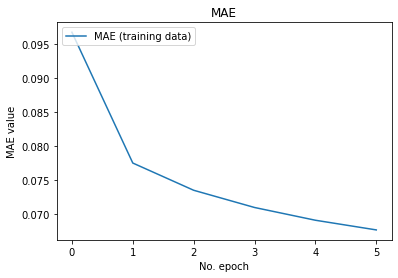

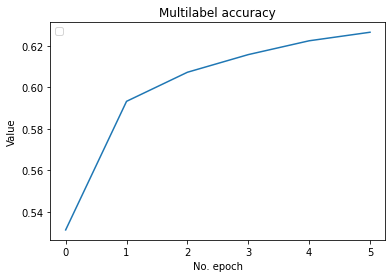

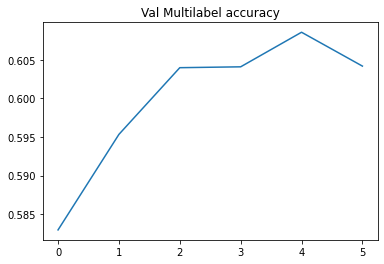

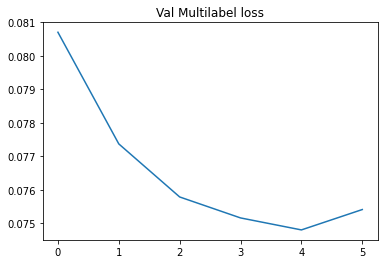

In [ ]:
y_pred = predict_using_model(model)

print('Hamming loss : {}'.format(hamming_loss(y_test,y_pred)))
print('Accuracy : {}'.format(accuracy_score(y_test,y_pred)))

plot_loss(history)
plt.title("Val Multilabel accuracy")
plt.plot(history.history['val_multilabel_accuracy'])
plt.show()

plt.title("Val Multilabel loss")
plt.plot(history.history['val_loss'])
plt.show()